In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
from glob import glob
import os

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
#sb.set_theme(style='whitegrid', palette='pastel')
sb.set_context("notebook", rc={"lines.linewidth": 0.6})
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

In [3]:
def get_msc(x, smooth=True):
    msc = x.groupby('time.dayofyear').mean()
    msc_0 = msc.copy().assign_coords(dayofyear=np.arange(1 - 366, 1))
    msc_1 = msc.copy().assign_coords(dayofyear=np.arange(367, 367 + 366))
    msc_stack = xr.concat((msc_0, msc, msc_1), dim='dayofyear')
    msc_stack = msc_stack.rolling(dayofyear=31, min_periods=4, center=True).median()
    msc_smooth = msc_stack.rolling(dayofyear=41, min_periods=21, center=True).mean().sel(dayofyear=slice(1, 366))

    if smooth:
        return msc_smooth
    else:
        return msc

def add_timescales(x):
    for var in x.data_vars:
        x[var + '_msc'] = get_msc(x[var])
        x[var + '_iav'] = x[var].groupby('time.dayofyear') - x[var + '_msc']
        x[var + '_ym'] = x[var].groupby('time.year').mean()
    return x

def drop_first_year(x: xr.Dataset):
    x = x.sel(
        time=slice(
            str(x.time.dt.year[0].item() + 1),
            None
        )
    )
    return x

def compute_metrics(x, dim=None):
    res = xr.Dataset()
    for metric in ['nse', 'rmse']:
        for ext in ['', '_msc', '_iav']:
            obs = x['GPP' + ext]
            mod = x['GPP_hat' + ext]

            if dim == 'time':
                if ext == '_msc':
                    obs_dim = mod_dim = 'dayofyear'
                else:
                    obs_dim = mod_dim = 'time'
            elif dim is None:
                obs_dim = set(obs.dims) - {'model', 'quantile'}
                mod_dim = set(mod.dims) - {'model', 'quantile'}

            if metric == 'nse':
                met = 1 - (
                    ((obs - mod) ** 2).sum(mod_dim) / ((obs - obs.mean(obs_dim)) ** 2).sum(obs_dim)
                )
                met = 1 / (2 - met)
            elif metric == 'rmse':
                met = ((obs - mod) ** 2).mean(mod_dim) ** 0.5

            res[metric + ext] = met

    return res

In [40]:
models = [os.path.basename(d) for d in glob('../logs/*')]
models = models[:-1]
models

['conv1d', 'simplemlp', 'linear', 'resnet', 'attn', 'lstm']

In [59]:
ds_CO2 = xr.open_dataset('../logs/conv1d/sensitivity/CO2/predictions.nc').drop('GPP_hat')
ds_causal = xr.open_dataset('../logs/conv1d/sensitivity/causal/predictions.nc').drop('GPP_hat')
ds_time = xr.open_dataset('../logs/conv1d/extrap/time/predictions.nc').drop('GPP_hat')

for data, dirname in zip([ds_CO2, ds_causal, ds_time], ['CO2', 'causal', 'time']):
    dt = []
    for model in models:
        print(model)
        if dirname == 'time':
            dt.append(xr.open_dataset(f'../logs/{model}/extrap/{dirname}/predictions.nc')['GPP_hat'])
        else:
            dt.append(xr.open_dataset(f'../logs/{model}/sensitivity/{dirname}/predictions.nc')['GPP_hat'])

    data['GPP_hat'] = xr.concat(dt, dim='model')

ds_CO2 = drop_first_year(ds_CO2).load()
ds_causal = drop_first_year(ds_causal).load()
ds_time = drop_first_year(ds_time).load()

ds_CO2 = add_timescales(ds_CO2)
ds_causal = add_timescales(ds_causal)
ds_time = add_timescales(ds_time)

ds_CO2['model'] = models
ds_causal['model'] = models
ds_time['model'] = models

met_CO2_global = compute_metrics(ds_CO2)
met_causal_global = compute_metrics(ds_causal)
met_time_global = compute_metrics(ds_time)

met_CO2 = compute_metrics(ds_CO2, dim='time')
met_causal = compute_metrics(ds_causal, dim='time')
met_time = compute_metrics(ds_time, dim='time')

conv1d
simplemlp
linear
resnet
attn
lstm
conv1d
simplemlp
linear
resnet
attn
lstm
conv1d
simplemlp
linear
resnet
attn
lstm


In [17]:
def plot_ts(pred, obs, co2, line_scale=1.0, locs=range(10), axes_only=False, axes=None, add_legend=False):
    if axes is None:
        fig, axes = plt.subplots(len(locs), 2, figsize=(20, len(locs) * 2), gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.13}, sharex='col', sharey='row', squeeze=False)

    if axes_only:
        return fig, axes

    for l, loc in enumerate(locs):
        pred_ = pred.isel(location=loc)
        obs_ = obs.isel(location=loc)
        co2_ = co2.isel(location=loc)
        for s in range(2):
            if s == 0:
                line_scale_ = line_scale
            if s == 1:
                pred_ = pred_.sel(time=str(pred_.time.dt.year[-1].item()))
                obs_ = obs_.sel(time=str(obs_.time.dt.year[-1].item()))
                line_scale_ = line_scale * 2.0
            ax = axes[l, s]

            ax.plot(
                pred_.time,
                obs_,
                color='k',
                lw=0.5 * line_scale_,
                alpha=0.7,
                label='Observed GPP' if s == 0 else '__nolegend__')
            if s == 0:
                m = obs_.rolling(time=365 * 2, center=True).mean()
                ax.plot(
                    m.time,
                    m,
                    color='k',
                    lw=1.8 * line_scale_,
                    alpha=1.0,
                    zorder=9999,
                    label='Observed GPP trend' if s == 0 else '__nolegend__')
            ax.fill_between(
                x=pred_.time,
                y1=pred_.isel(quantile=0), 
                y2=pred_.isel(quantile=2),
                edgecolor='none',
                facecolor='tab:orange',
                alpha=0.4,
                label='Ensemble GPP 0.1-0.9 quantile' if s == 0 else '__nolegend__')
            ax.plot(
                pred_.time,
                pred_.isel(quantile=1),
                color='tab:orange',
                lw=0.5 * line_scale_,
                alpha=0.9,
                label='Ensemble GPP median' if s == 0 else '__nolegend__')

            if s == 0:
                m = pred_.isel(quantile=1).rolling(time=365 * 2, center=True).mean()
                ax.plot(
                    m.time,
                    m,
                    color='tab:red',
                    lw=1.5 * line_scale_,
                    alpha=1.0,
                    zorder=9999,
                    label='Ensemble GPP median trend' if s == 0 else '__nolegend__')
                ax2=ax.twinx()
                ax2.plot(
                    co2_.time,
                    co2_,
                    color='tab:blue',
                    lw=1.5 * line_scale_,
                    alpha=0.7,
                    zorder=9999,
                    label='Atmospheric CO2 forcing')
                ax2.set_ylabel('CO2 [ppm]')
                ax.set_ylabel('GPP')

                if add_legend:
                    ax2.legend(loc=1)
                    ax.legend(ncol=3)


In [42]:
def plot_multimodel_ts(ds):
    fig, axes = plot_ts(pred=None, obs=None, co2=None, locs=range(len(models)), axes_only=True)

    for i, model in enumerate(models):
        plot_ts(pred=ds.GPP_hat.sel(model=model), obs=ds.GPP, co2=ds.co2, locs=range(1), axes=axes[i:i+1, :], add_legend=i==0)
        axes[i, 0].set_title(model)

In [63]:
ds_causal_diff = ds_causal.isel(time=slice(-len(ds_time['time']), None)) - ds_time

In [58]:
ds_time

<xarray.Dataset>
Dimensions:      (time: 31046, location: 15, quantile: 3, model: 6, dayofyear: 366)
Coordinates:
  * location     (location) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time         (time) datetime64[ns] 2016-01-01T12:00:00 ... 2100-12-31T12:...
    cluster      (location) int64 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3
  * quantile     (quantile) float64 0.1 0.5 0.9
  * dayofyear    (dayofyear) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
  * model        (model) <U9 'conv1d' 'simplemlp' 'linear' ... 'attn' 'lstm'
Data variables: (12/33)
    var1         (time, location) float32 4.264 3.412 4.906 ... 275.0 275.0
    var2         (time, location) float32 -20.96 -24.93 -20.79 ... 9.575 9.575
    var3         (time, location) float32 6.035e-05 1.288e-13 ... 0.254 0.254
    var4         (time, location) float32 6.238 5.429 4.364 ... 5.289 4.06 4.06
    var5         (time, location) float32 3.406 2.824 4.61 ... 2.842 6.016 6.016
    var6         (time, location) float32 -0.2345 -0.03231 ... -1.927 -1.927
    ...           ...
    GPP_msc      (dayofyear, location) float64 0.4098 0.4018 ... 0.734 0.7647
    GPP_iav      (time, location) float64 0.2195 -0.1596 ... 0.6788 0.8092
    code_msc     (dayofyear, location) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    code_iav     (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    GPP_hat_msc  (model, quantile, dayofyear, location) float64 0.6956 ... 2.081
    GPP_hat_iav  (model, quantile, time, location) float64 -0.6832 ... 3.161

In [62]:
ds_causal.isel(time=slice(-len(ds_time['time']), None))

<xarray.Dataset>
Dimensions:      (time: 31046, location: 1, quantile: 3, model: 6, dayofyear: 366)
Coordinates:
  * location     (location) int64 1
  * time         (time) datetime64[ns] 2016-01-01T12:00:00 ... 2100-12-31T12:...
    cluster      (location) int64 1
  * quantile     (quantile) float64 0.1 0.5 0.9
  * dayofyear    (dayofyear) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
  * model        (model) <U9 'conv1d' 'simplemlp' 'linear' ... 'attn' 'lstm'
Data variables: (12/33)
    var1         (time, location) float32 4.264 6.708 4.675 ... 8.598 16.2 12.57
    var2         (time, location) float32 -20.96 -18.52 -22.16 ... -14.02 -13.29
    var3         (time, location) float32 6.035e-05 1.324e-13 ... 0.09687 0.8998
    var4         (time, location) float32 6.238 6.299 6.039 ... 5.053 2.406
    var5         (time, location) float32 4.296 4.296 4.296 ... 4.296 4.296
    var6         (time, location) float32 -0.2345 -0.2595 ... -0.6269 -0.6292
    ...           ...
    GPP_msc      (dayofyear, location) float64 0.4032 0.403 ... 0.4037 0.4034
    GPP_iav      (time, location) float64 -0.07582 0.04706 ... 0.2675 0.1528
    code_msc     (dayofyear, location) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    code_iav     (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    GPP_hat_msc  (model, quantile, dayofyear, location) float64 0.2823 ... 0....
    GPP_hat_iav  (model, quantile, time, location) float64 -0.2603 ... 3.235

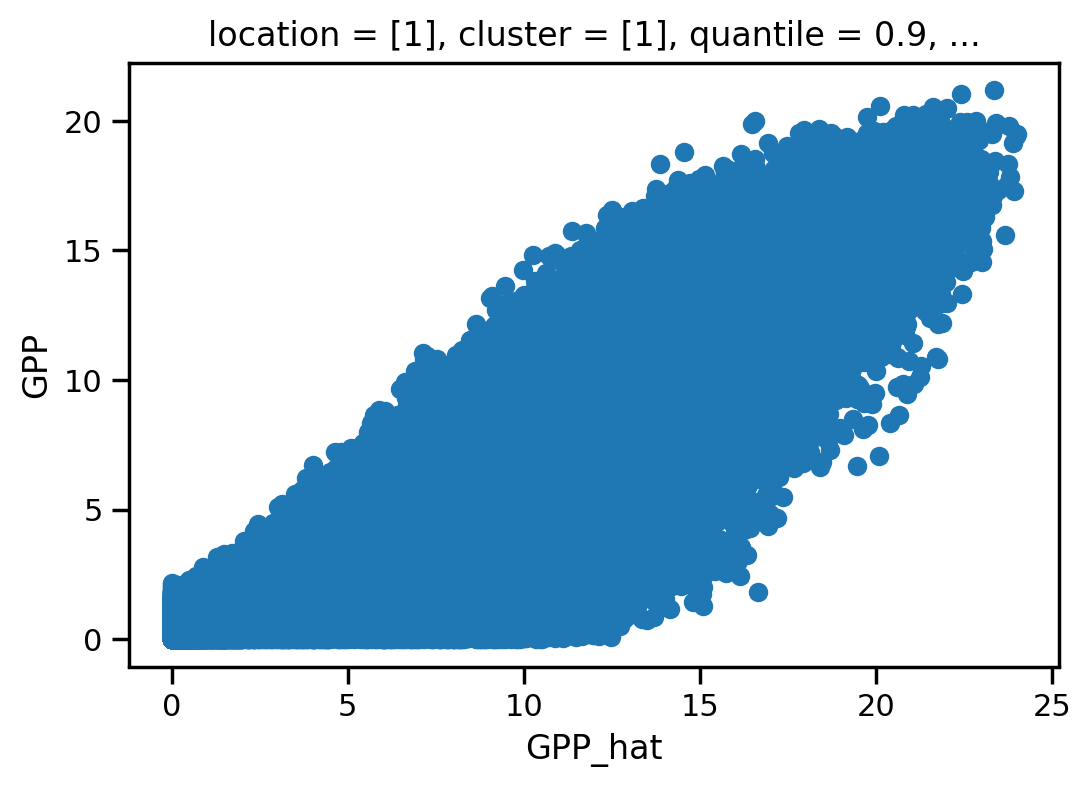

In [27]:
ds_causal.isel(quantile=2).plot.scatter('GPP_hat', 'GPP')

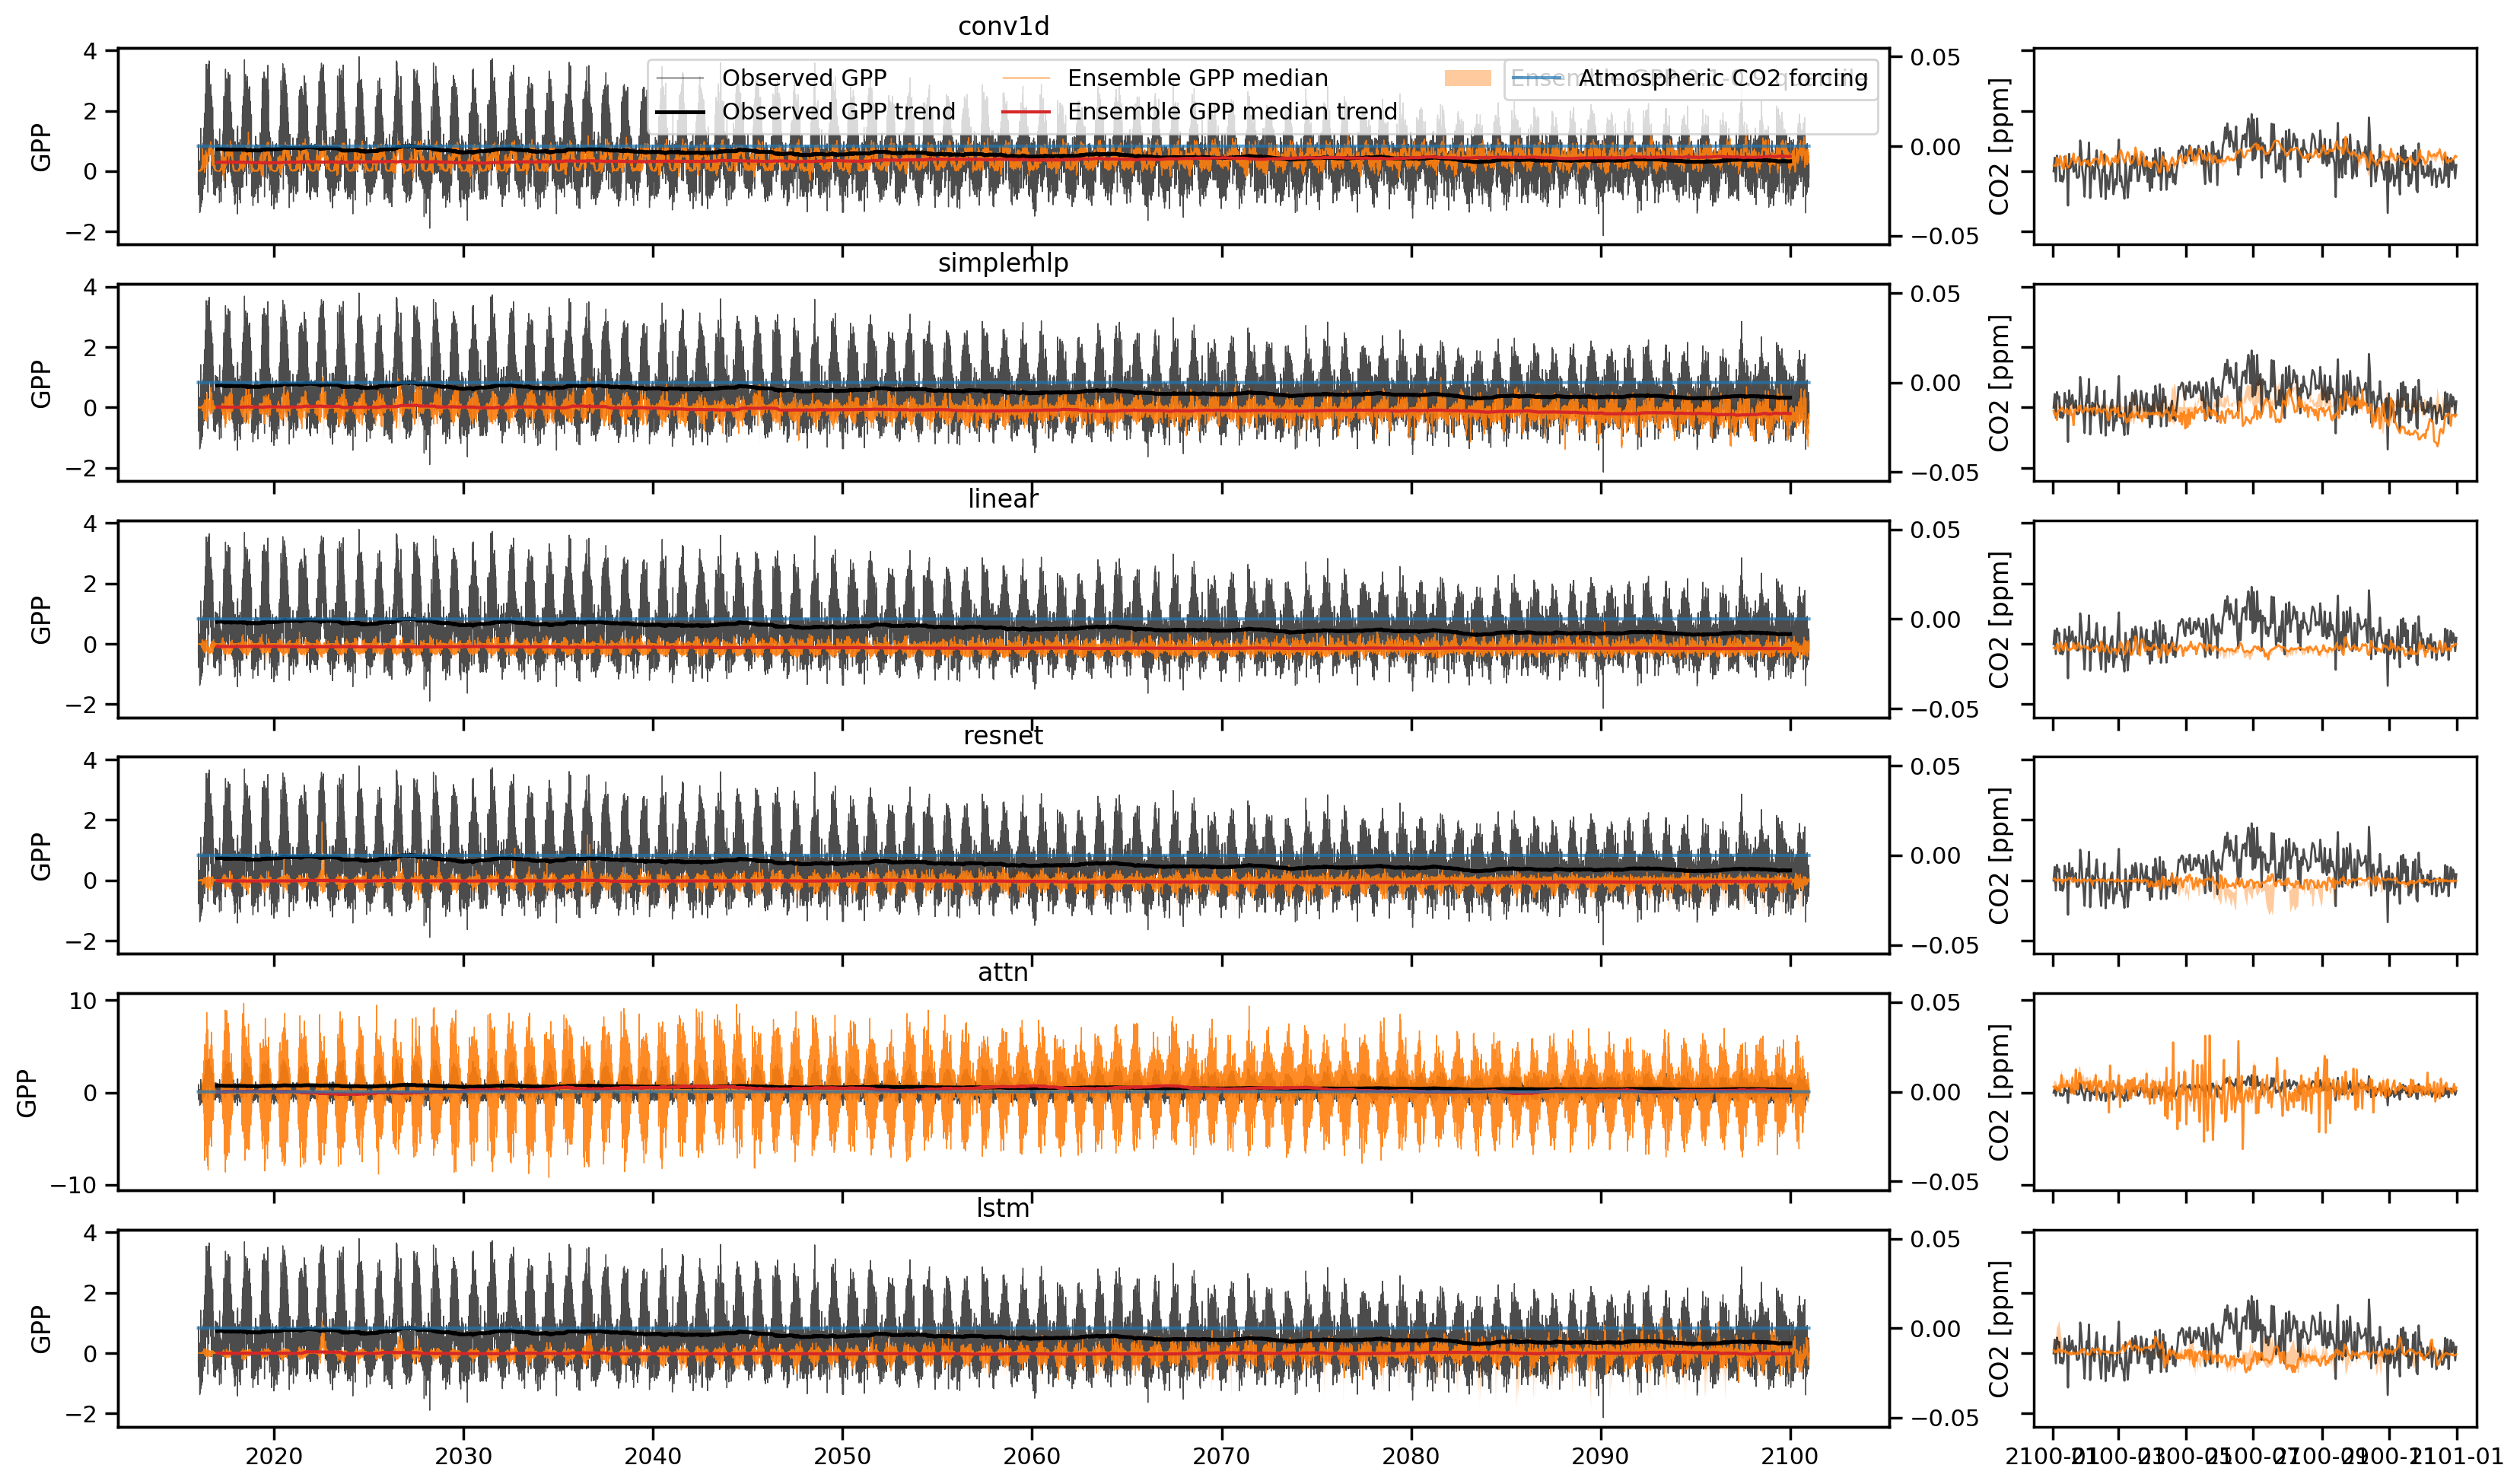

In [64]:
plot_multimodel_ts(ds_causal_diff)

In [65]:
ds_causal_diff

<xarray.Dataset>
Dimensions:      (location: 1, time: 31046, quantile: 3, dayofyear: 366, model: 6)
Coordinates:
  * location     (location) int64 1
  * time         (time) datetime64[ns] 2016-01-01T12:00:00 ... 2100-12-31T12:...
    cluster      (location) int64 1
  * quantile     (quantile) float64 0.1 0.5 0.9
  * dayofyear    (dayofyear) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
  * model        (model) <U9 'conv1d' 'simplemlp' 'linear' ... 'attn' 'lstm'
Data variables: (12/33)
    var1         (time, location) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    var2         (time, location) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    var3         (time, location) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    var4         (time, location) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    var5         (time, location) float32 0.8895 0.9317 1.547 ... -0.02433 0.158
    var6         (time, location) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...           ...
    GPP_msc      (dayofyear, location) float64 -0.006581 -0.006582 ... -0.00654
    GPP_iav      (time, location) float64 -0.2953 -0.04291 ... -0.2356 0.2072
    code_msc     (dayofyear, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    code_iav     (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    GPP_hat_msc  (model, quantile, dayofyear, location) float64 -0.4133 ... -...
    GPP_hat_iav  (model, quantile, time, location) float64 0.4228 ... 0.3657

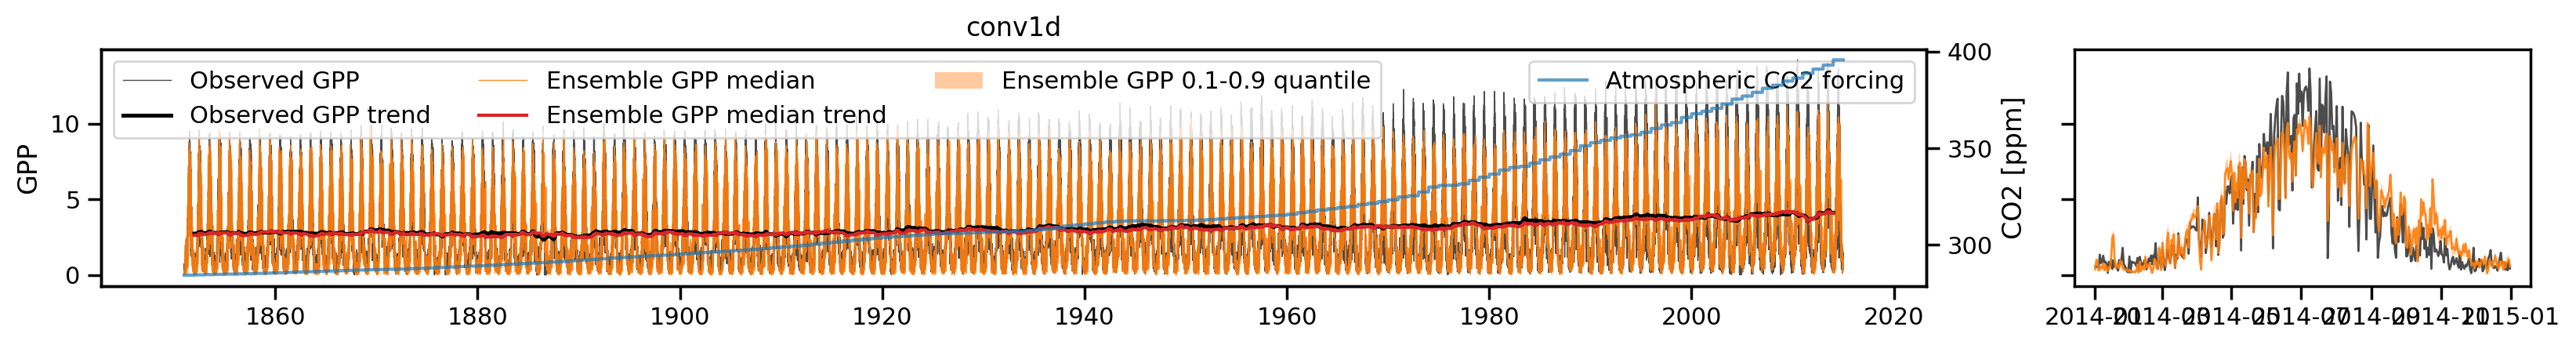

In [33]:
plot_multimodel_ts(ds_space)

In [7]:
met_space_global_df = met_space_global.sel(quantile=0.5).to_dataframe().reset_index()
met_time_global_df = met_time_global.sel(quantile=0.5).to_dataframe().reset_index()
met_val_global_df = met_val_global.sel(quantile=0.5).to_dataframe().reset_index()

met_space_global_df['mode'] = 'space'
met_time_global_df['mode'] = 'time'
met_val_global_df['mode'] = 'val'

met_global_df = pd.concat((met_space_global_df, met_time_global_df, met_val_global_df)).drop('quantile', axis=1)
met_global_df = pd.melt(met_global_df, id_vars=['model', 'mode'], value_vars=[f'nse', f'nse_msc', f'nse_iav'], var_name='scale')

In [8]:
met_space_df = met_space.sel(quantile=0.5).to_dataframe().reset_index()
met_time_df = met_time.sel(quantile=0.5).to_dataframe().reset_index()
met_val_df = met_val.sel(quantile=0.5).to_dataframe().reset_index()

met_space_df['mode'] = 'space'
met_time_df['mode'] = 'time'
met_val_df['mode'] = 'val'

met_df = pd.concat((met_space_df, met_time_df, met_val_df)).drop('quantile', axis=1)
met_df = pd.melt(met_df, id_vars=['model', 'mode', 'location'], value_vars=[f'nse', f'nse_msc', f'nse_iav'], var_name='scale')

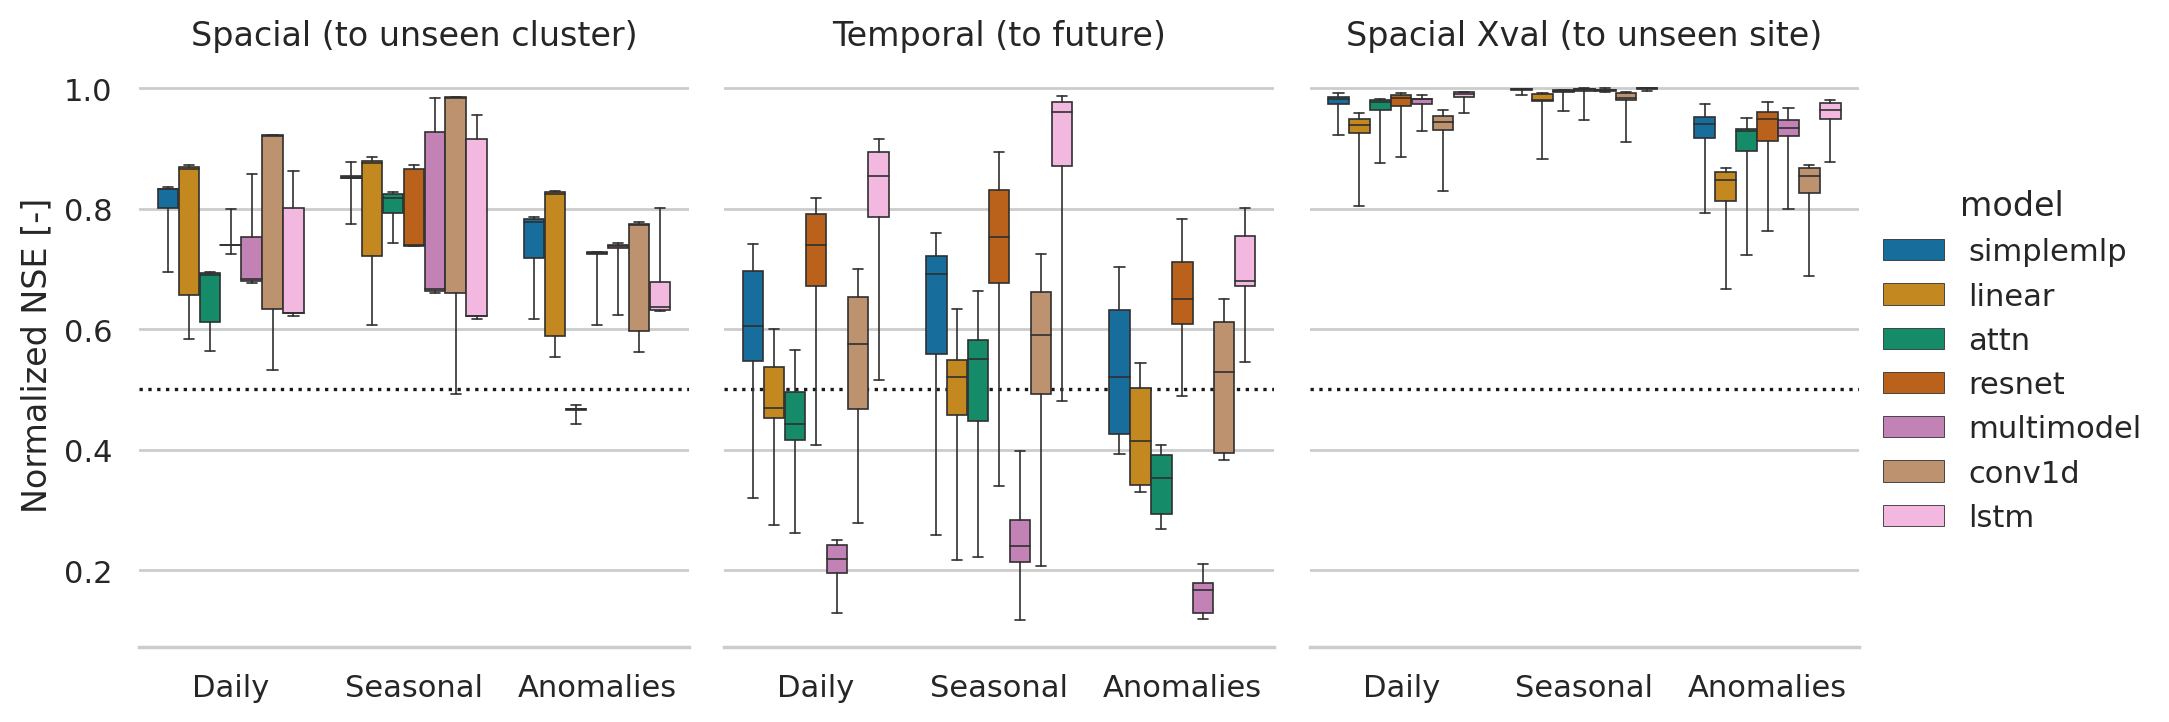

In [9]:


g = sb.catplot(
    x='scale', 
    y='value',
    hue='model',
    col='mode',
    kind='box',
    data=met_df,
    palette='colorblind',
    height=4,
    aspect=0.8,
    whis=100000)

g.set_axis_labels('', 'Normalized NSE [-]')
g.set_xticklabels(['Daily', 'Seasonal', 'Anomalies'])
#g.set_titles(['1', '2', '3'])
g.despine(left=True)

for i, ax in enumerate(g.axes.flat):
    titles = [
        'Spacial (to unseen cluster)',
        'Temporal (to future)',
        'Spacial Xval (to unseen site)'
    ]
    ax.set_title(titles[i])
    ax.axhline(0.5, color='k', ls=':', lw=1.2, zorder=-1)

In [303]:
met_global_rmse = met_val_global_df.set_index('model')[['rmse']].rename(columns={'rmse': 'xval'})
met_global_rmse['space'] = met_space_global_df.set_index('model')['rmse']
met_global_rmse['time'] = met_time_global_df.set_index('model')['rmse']
met_global_rmse.columns = [
    'Spacial Xval (to unseen site)',
    'Spacial (to unseen cluster)',
    'Temporal (to future)',
]

mn, mx = met_global_rmse.stack().quantile([0.1, 0.9])
def make_pretty(styler: pd.io.formats.style.Styler):
    styler.set_caption('Model extrapolation skill (RMSE)')
    styler.format(precision=2)
    styler.background_gradient(axis=None, vmin=mn, vmax=mx, cmap='PiYG_r')
    return styler

met_global_rmse.T.style.pipe(make_pretty)

model,simplemlp,linear,attn,resnet,multimodel,conv1d,lstm
Spacial Xval (to unseen site),0.61,1.10,0.77,0.65,0.62,1.04,0.46
Spacial (to unseen cluster),1.32,1.43,1.93,1.57,1.71,1.40,1.87
Temporal (to future),3.46,4.39,4.65,2.69,7.93,3.79,1.97


In [11]:
met_space_df= met_space.to_dataframe().reset_index()
met_time_df= met_time.to_dataframe().reset_index()

In [12]:
met_space_df

,location,quantile,model,cluster,nse,nse_msc,nse_iav,rmse,rmse_msc,rmse_iav
0,11,0.1,simplemlp,3,0.665088,0.638485,0.734919,2.066836,1.842496,0.873332
1,11,0.1,linear,3,0.757534,0.748553,0.765921,1.647798,1.419158,0.803893
2,11,0.1,attn,3,0.564934,0.603072,0.462126,2.555987,1.986509,1.568806
3,11,0.1,resnet,3,0.550034,0.519252,0.635184,2.634359,2.356071,1.102037
4,11,0.1,multimodel,3,0.564093,0.525966,0.700262,2.560362,2.324581,0.951372
...,...,...,...,...,...,...,...,...,...,...
100,15,0.9,attn,3,0.739651,0.949963,0.444626,1.738533,0.565747,1.635508
101,15,0.9,resnet,3,0.911622,0.944351,0.825165,0.912395,0.598402,0.673600
102,15,0.9,multimodel,3,0.767277,0.780375,0.747198,1.613847,1.307733,0.851196
103,15,0.9,conv1d,3,0.909561,0.977108,0.755274,0.924016,0.377314,0.833000


In [13]:
def sel(df, **sel):
    for k, v in sel.items():
        if (not isinstance(v, str)) and hasattr(v, '__iter__'):
            df = df.loc[df[k].isin(v), :]
        else:
            df = df.loc[df[k] == v, :]
    return df

In [14]:
def df_diff(x, y):
    x = x.reset_index()
    y = y.reset_index()
    for m in ['nse', 'nse_msc', 'nse_iav', 'rmse', 'rmse_msc', 'rmse_iav']:
        x[m] = x[m] - y[m]
    return x

In [308]:
df_diff(sel(d, quantile=0.5), sel(d, quantile=0.1))

,index,location,quantile,model,cluster,nse,nse_msc,nse_iav,rmse,rmse_msc,rmse_iav
0,6,11,0.5,conv1d,3,0.011663,0.028754,-0.019714,-0.067253,-0.224754,0.044498
1,24,12,0.5,conv1d,3,-0.028535,-0.050656,-0.004010,0.125784,0.161190,0.011849
2,42,13,0.5,conv1d,3,-0.032933,-0.061346,-0.009037,0.113291,0.144984,0.021792
3,60,14,0.5,conv1d,3,0.010158,0.026593,-0.019879,-0.058238,-0.212332,0.044410
4,78,15,0.5,conv1d,3,0.011678,0.028619,-0.019502,-0.067219,-0.218785,0.044260


In [304]:
sel(d, quantile=0.1).reset_index()

,index,location,quantile,model,cluster,nse,nse_msc,nse_iav,rmse,rmse_msc,rmse_iav
0,0,11,0.1,conv1d,3,0.911440,0.957018,0.797069,0.907891,0.518922,0.733729
1,18,12,0.1,conv1d,3,0.560333,0.543151,0.566016,2.122379,1.508403,1.447227
2,36,13,0.1,conv1d,3,0.666094,0.722180,0.605498,1.509161,0.935073,1.145684
3,54,14,0.1,conv1d,3,0.912315,0.959794,0.793737,0.897414,0.498420,0.734722
4,72,15,0.1,conv1d,3,0.909630,0.955488,0.794893,0.923632,0.532054,0.743350


,location,quantile,model,cluster,nse,nse_msc,nse_iav,rmse,rmse_msc,rmse_iav
6,11,0.5,conv1d,3,0.923103,0.985772,0.777355,0.840638,0.294169,0.778227
24,12,0.5,conv1d,3,0.531798,0.492496,0.562006,2.248163,1.669593,1.459077
42,13,0.5,conv1d,3,0.633161,0.660834,0.596462,1.622451,1.080058,1.167476
60,14,0.5,conv1d,3,0.922473,0.986387,0.773857,0.839176,0.286088,0.779133
78,15,0.5,conv1d,3,0.921307,0.984107,0.775391,0.856413,0.313269,0.787610


<AxesSubplot:xlabel='model', ylabel='nse'>

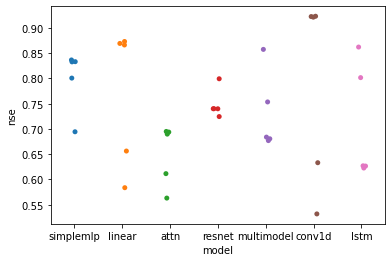

In [70]:
sb.stripplot(x='model', y='nse', data=sel(met_space_df, quantile=0.5))

<AxesSubplot:xlabel='model', ylabel='rmse'>

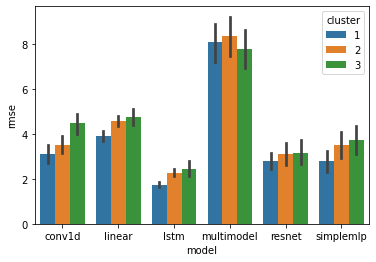

In [258]:
sb.barplot(x='model', y='rmse', hue='cluster', data=met_time_df)